In [1]:
from typing import Optional, Callable
import os.path as osp

# Data science packages
import pandas as pd 
import numpy as np

# Chemoinformatics packages
from rdkit import Chem
from rdkit.Chem import PeriodicTable

# Graph neural netowrks packages
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv
from torch_geometric.data import (
    DataLoader, 
    InMemoryDataset, 
    download_url,
    Data
)

## Feature vectors

In [2]:
def oneHotEncoding(x, values):
    """
    Helper function to encode the given value as a one-hot vector

    :param x: value to encode
    :param values: encoding vector, i.e. contains every possible values of x
    """

    return [int(x == value) for value in values]

In [3]:
def getAtomFeatureVector(atom):

    # Setup one-hot encoding vectors
    atoms = ["B", "C", "N", "O", "F", "Si", "P", "S", "As", "Se", "Br", "Te", "I", "At"]
    degrees = list(range(6))
    hybridizations = [
        Chem.HybridizationType.SP,
        Chem.HybridizationType.SP2,
        Chem.HybridizationType.SP3,
        Chem.HybridizationType.SP3D,
        Chem.HybridizationType.SP3D2,
        Chem.HybridizationType.OTHER,
    ]
    hydrogens = list(range(5))
    chirality_types = [
        Chem.ChiralType.CHI_TETRAHEDRAL_CW, 
        Chem.ChiralType.CHI_TETRAHEDRAL_CCW
    ]
    
#     atom_encoding = [
#         [*[0]*(len(atoms)-1) + [1]] 
#         if atom.IsMetal()
#         else oneHotEncoding(atom.GetSymbol(), atoms)
#     ]

    return [
        *oneHotEncoding(atom.GetSymbol(), atoms),
        *oneHotEncoding(atom.GetDegree(), degrees),
        atom.GetFormalCharge(),
        *oneHotEncoding(atom.GetHybridization(), hybridizations),
        *oneHotEncoding(atom.GetTotalNumHs(), hydrogens),
        int(atom.GetChiralTag() != Chem.ChiralType.CHI_UNSPECIFIED),
        *oneHotEncoding(atom.GetChiralTag(), chirality_types)
    ]

In [48]:
def getBondFeatureVector(bond):
    
    # Setup one-hot encoding vectors
    bond_types = [
        Chem.BondType.SINGLE, 
        Chem.BondType.DOUBLE, 
        Chem.BondType.TRIPLE, 
        Chem.BondType.AROMATIC
    ]
    
    stereo_types = [
        Chem.BondStereo.STEREONONE, 
        Chem.BondStereo.STEREOANY, 
        Chem.BondStereo.STEREOZ, 
        Chem.BondStereo.STEREOE
    ]
    
    return [
        *oneHotEncoding(bond.GetBondType(), bond_types),
        int(bond.GetIsConjugated()),
        int(bond.IsInRing()),
        *oneHotEncoding(bond.GetStereo(), stereo_types)
    ]


def getEdgeTypes(e):
    
    edge_types = np.zeros(e.shape[0], dtype=int)
    
    for row in range(e.shape[0]):
        
        bond_type = list(e[row, :4]).index(1)
        is_conjugated = int(e[row, 4:5])
        in_ring = int(e[row, 5:6])
        stereo = list(e[row, 6:]).index(1)
                
        edge_type = (
            bond_type + 
            is_conjugated * 4 + 
            in_ring * 8 + 
            stereo * 16
        )
        
        edge_types[row] = edge_type
    
    return torch.tensor(edge_types, dtype=torch.long)

In [5]:
btypes = []
i = 0
for bond_type in range(4):
    for conj in range(2):
        for in_ring in range(2):
            for stereo in range(4):
                i += 1
                btype = bond_type + conj * 4 + in_ring * 8 + stereo * 16
                
                if btype not in btypes:
                    btypes.append(btype)
                else:
                    print(bond_type, conj, in_ring, stereo)
                    print(btype)
                    raise ValueError
                    
print(sorted(btypes))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]


In [6]:
def createDataObjectFromSmiles(smiles: str, y: any):
    
    rd_mol = Chem.MolFromSmiles(smiles)
    
    # x has shape [num_atoms, num_features]
    x = torch.tensor([
        getAtomFeatureVector(atom)
        for atom in rd_mol.GetAtoms()
    ])
    
    edge_indices, edge_attrs, edge_types = [], [], []
    for bond in rd_mol.GetBonds():
        
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        
        e = getBondFeatureVector(bond)
        
        # Treat molecules as undirected graphs
        edge_indices += [[i, j], [j, i]]
        edge_attrs += [e, e]
        
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().view(2, -1)
    edge_attr = torch.tensor(edge_attrs, dtype=torch.long).view(-1, 10)
    
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, smiles=smiles)
    data.y = y
    
    return data

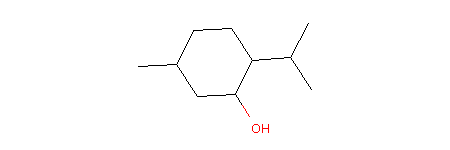

In [82]:
mol = Chem.MolFromSmiles("CC1CCC(C(C1)O)C(C)C")
mol

## Create data set

In [7]:
class SolubilityDataset(InMemoryDataset):
    
    def __init__(
        self, 
        tag: str,
        transform: Optional[Callable] = None, 
        pre_transform: Optional[Callable] =None,
        pre_filter: Optional[Callable] = None
    ):
        self.name = "solubility"
        self.tag = tag
        super().__init__("../data", transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_dir(self) -> str:
        return osp.join(self.root, self.name)

    @property
    def processed_dir(self) -> str:
        return osp.join(self.root, self.name)
        
    @property
    def raw_file_names(self):
        return f"ESOL_{self.tag}.csv"
    
    @property
    def processed_file_names(self):
        return f"ESOL_{self.tag}.pt"
        
    def process(self):
        df = pd.read_csv(self.raw_paths[0])
        data_list = df[["smiles", "ESOL"]].apply(
            lambda row: createDataObjectFromSmiles(*row),
            axis=1
        ).tolist()
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), osp.join(self.processed_dir, self.processed_file_names))

## Relational graph neural network (RGCN)

The GNN architecture used to predict the solubility of molecules is a relational GNN. A RGNN model extends a standard GCN model by also using edge types in the node update function,

$$
h_v^{(l+1)} = ReLU\left(\sum_{r \in R} \sum_{u \in N_v^r} W_r^{(l)} h_u^{(l)} + W_0^{(l)} h_v^{(l)}\right),
$$

with $R$ the set of edge types and $W_r^{(l)}$ a weight matrix of edge type $r$ of layer $l$ with learnable 
parameters and $N_v^r$ is the set of neighboring atoms with edge type $r$.

In [8]:
class MLP(torch.nn.Module):
    
    def __init__(self, input_units, hidden_units):
        super().__init__()
        
        self.lin1 = Linear(input_units, hidden_units)
        self.lin2 = Linear(hidden_units, hidden_units)
        self.lin3 = Linear(hidden_units, 1)
        
    def forward(self, x):
        
        h = self.lin1(x)
        h = F.relu(h)
        h = F.dropout(0.1)
        
        h = self.lin2(h)
        h = F.relu(h)
        h = F.dropout(0.1)
        
        h = self.lin3(h)
        h = F.relu(h)
        
        return h


In [9]:
class MolecularEmbedding(torch.nn.Module):
    
    def __init__(self, input_units):
        super().__init__()
        
        self.lin1 = Linear(input_units, 1)
        
    def forward(self, x):
        
        # Compute weights for each node
        omega = self.lin1(x)
        omega = F.sigmoid(omega)
        
        # Compute molecular embedding by a weighted sum
        return omega @ x

In [65]:
class RGCN(torch.nn.Module):
    
    def __init__(self, num_node_features: int):
        super().__init__()
        
        # Define layers
        self.rgcn1 = RGCNConv(num_node_features, 256, 65, 65)
        self.rgcn2 = RGCNConv(256, 256, 65, 65)
        self.molecularEmbedding = MolecularEmbedding(256)
        self.mlp = MLP(256, 64)
        
    def forward(self, x, edge_index, edge_attr):
        
        # Convert edge_attr to edge_type
        edge_type = getEdgeTypes(edge_attr)
        print(edge_type.dtype)
        
        # Pass through two RGCN layers
        h = self.rgcn1(x, edge_index, edge_type)
        h = F.relu(h)
        h = F.dropout(0.5, learning=self.training)
        
        h = self.rgcn2(h, edge_index, edge_type)
        h = F.relu(h)
        h = F.dropout(0.5, learning=self.training)
        
        # Create molecular embedding
        molecular_embedding = self.molecularEmbedding(h)
        
        # Pass through a three layer MLP to obtain prediction
        y = self.mlp(molecular_embedding)
        
        return y

## Training RGCN

In [11]:
data = pd.read_csv("../data/solubility/ESOL.csv")
data.head()

,smiles,ESOL,group
0,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...,-0.77,training
1,Cc1occc1C(=O)Nc1ccccc1,-3.30,training
2,CC(C)=CCCC(C)=CC=O,-2.06,training
3,c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21,-7.87,training
4,c1ccsc1,-1.33,training


In [12]:
train_data = data.query("group == 'training'")
test_data = data.query("group == 'test'")
val_data = data.query("group == 'valid'")

In [13]:
train_data.to_csv("../data/solubility/ESOL_train.csv")
test_data.to_csv("../data/solubility/ESOL_test.csv")
val_data.to_csv("../data/solubility/ESOL_val.csv")

In [14]:
train_data = SolubilityDataset(tag="train")
test_data = SolubilityDataset(tag="test")
val_data = SolubilityDataset(tag="val")

In [28]:
train_dataloader = DataLoader(train_data, batch_size=256)
test_dataloader = DataLoader(test_data, batch_size=256)
val_dataloader = DataLoader(val_data, batch_size=256)

In [29]:
def train(loader, model, criterion, optimizer):
    # Set model to train mode
    model.train()
    
    for data in loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        
def test(loader, model):
    # Set model to test mode
    model.eval()
    
    correct = 0
    for data in loader:
        out = model(data.x, data.edge_index)
        pred = out.armax(dim=1)
        correct += int((pred == data.y).sum())
        
    return correct/len(loader.dataset)

In [63]:
model = RGCN(num_node_features=35)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [64]:
print("Epoch \t train_acc \t val_acc \t test_acc")
for epoch in range(500):
    train(train_dataloader, model, criterion, optimizer)
    
    train_acc = test(train_dataloader, model)
    vall_acc = test(val_dataloader, model)
    test_acc = test(test_dataloader, model)
    
    if epoch % 10 == 0:
        print(f"{epoch} \t {train_acc} \t {val_acc} \t {test_acc}")

Epoch 	 train_acc 	 val_acc 	 test_acc
torch.int64


RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'mat2' in call to _th_mm_out

In [93]:
for data in train_dataloader:
    print(data)

Batch(batch=[3374], edge_attr=[6920, 10], edge_index=[2, 6920], smiles=[256], x=[3374, 35], y=[256])
Batch(batch=[3506], edge_attr=[7270, 10], edge_index=[2, 7270], smiles=[256], x=[3506, 35], y=[256])
Batch(batch=[3478], edge_attr=[7164, 10], edge_index=[2, 7164], smiles=[256], x=[3478, 35], y=[256])
Batch(batch=[1593], edge_attr=[3266, 10], edge_index=[2, 3266], smiles=[120], x=[1593, 35], y=[120])
